In [36]:
import os.path as ops
import numpy as np
import torch
import cv2
import time
from dataset.dataset_utils import TUSIMPLE, TUSIMPLE_AUG
from Lanenet.model2 import Lanenet

# Build The datasets

In [37]:
# root = '/Users/smiffy/Documents/GitHub/TUSIMPLE/Data_Tusimple_PyTorch/training'
# root = 'TUSIMPLE/txt_for_local'
root = '/root/car_data_new'
train_set = TUSIMPLE_AUG(root=root, flag='train')
valid_set = TUSIMPLE_AUG(root=root, flag='valid')
test_set = TUSIMPLE_AUG(root=root, flag='test')

print('train_set length {}'.format(len(train_set)))
print('valid_set length {}'.format(len(valid_set)))
print('test_set length {}'.format(len(test_set)))

train_set length 24960
valid_set length 5346
test_set length 5346


In [38]:
gt, bgt, igt = train_set[0]
print('image type {}'.format(type(gt)))
print('image size {} \n'.format(gt.size()))

print('gt binary image type {}'.format(type(bgt)))
print('gt binary image size {}'.format(bgt.size()))
print('items in gt binary image {} \n'.format(torch.unique(bgt)))

print('gt instance type {}'.format(type(igt)))
print('gt instance size {}'.format(igt.size()))
print('items in gt instance {} \n'.format(torch.unique(igt)))

image type <class 'torch.Tensor'>
image size torch.Size([3, 256, 512]) 

gt binary image type <class 'torch.Tensor'>
gt binary image size torch.Size([256, 512])
items in gt binary image tensor([0, 1]) 

gt instance type <class 'torch.Tensor'>
gt instance size torch.Size([256, 512])
items in gt instance tensor([0, 1, 2]) 



# DataLoader

In [39]:
batch_size = 8

data_loader_train = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
data_loader_valid = torch.utils.data.DataLoader(valid_set, batch_size=1, shuffle=True, num_workers=0)
data_loader_test = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)

# Model and optim

In [40]:
learning_rate = 5e-4

In [41]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

LaneNet_model = Lanenet(2, 4)
LaneNet_model.to(device)
pretrained_weights = torch.load(r'/root/LaneNet-Pytorch-teach/LaneNet-PyTorch-master/TUSIMPLE/Lanenet_output/lanenet_epoch_8_batch_8_AUG.model', map_location=device)

LaneNet_model.load_state_dict(pretrained_weights, strict=False)  # strict=False 允许部分加载

params = [p for p in LaneNet_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=learning_rate, weight_decay=0.0002)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

/tmp/ipykernel_29737/1561641026.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_weights = torch.load(r'/root/LaneNet-Pytorch-teach/LaneNet-PyTorch-master/TUSI

In [42]:
num_epochs = 50
# num_epochs = 2

In [43]:
from Lanenet.cluster_loss3 import cluster_loss
criterion = cluster_loss()

In [44]:
from torch.autograd import Variable

In [45]:
loss_all = []
for epoch in range(15,num_epochs):
    LaneNet_model.train()
    ts = time.time()
    for iter, batch in enumerate(data_loader_train):
        input_image = Variable(batch[0]).to(device)
        binary_labels = Variable(batch[1]).to(device)
        instance_labels = Variable(batch[2]).to(device)
        
        binary_final_logits, instance_embedding = LaneNet_model(input_image)
        # loss = LaneNet_model.compute_loss(binary_logits=binary_final_logits, binary_labels=binary_labels,
        #                               instance_logits=instance_embedding, instance_labels=instance_labels, delta_v=0.5, delta_d=3)
        binary_segmenatation_loss, instance_segmenatation_loss = criterion(binary_logits=binary_final_logits, binary_labels=binary_labels,
                                       instance_logits=instance_embedding, instance_labels=instance_labels, delta_v=0.5, delta_d=3)
        
        # binary_segmenatation_loss = criterion(binary_final_logits, binary_labels)
        loss = 1*binary_segmenatation_loss + 1*instance_segmenatation_loss
        optimizer.zero_grad()
        loss_all.append(loss.item())
        loss.backward()
        optimizer.step()
        
        if iter % 40 == 0:
            print("epoch[{}] iter[{}] loss: [{}, {}] ".format(epoch, iter, binary_segmenatation_loss.item(), instance_segmenatation_loss.item()))
    lr_scheduler.step()
    print("Finish epoch[{}], time elapsed[{}]".format(epoch, time.time() - ts))
    torch.save(LaneNet_model.state_dict(), 
                       f"TUSIMPLE/Lanenet_output/lanenet_epoch_{epoch}_batch_{8}_AUG.model")

epoch[15] iter[0] loss: [0.035351820290088654, 0.07591531425714493] 
epoch[15] iter[40] loss: [0.043126486241817474, 0.08433555066585541] 
epoch[15] iter[80] loss: [0.043740808963775635, 0.0753730833530426] 
epoch[15] iter[120] loss: [0.04542377218604088, 0.07998567819595337] 
epoch[15] iter[160] loss: [0.05016503855586052, 0.12438071519136429] 
epoch[15] iter[200] loss: [0.034828487783670425, 0.0616428405046463] 
epoch[15] iter[240] loss: [0.04155220091342926, 0.07879751920700073] 
epoch[15] iter[280] loss: [0.04113888740539551, 0.07766755670309067] 
epoch[15] iter[320] loss: [0.04462040215730667, 0.07655412703752518] 
epoch[15] iter[360] loss: [0.04090138524770737, 0.09088414162397385] 
epoch[15] iter[400] loss: [0.0389535166323185, 0.06785660982131958] 
epoch[15] iter[440] loss: [0.05328337475657463, 0.25530388951301575] 
epoch[15] iter[480] loss: [0.04090871289372444, 0.07279812544584274] 
epoch[15] iter[520] loss: [0.04140777885913849, 0.09478525817394257] 
epoch[15] iter[560] los

KeyboardInterrupt: 

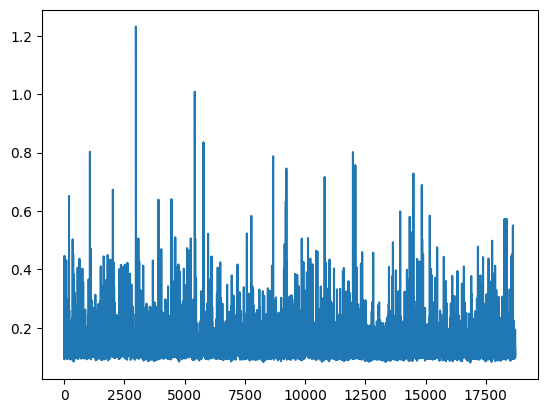

In [ ]:
import matplotlib.pylab as plt
plt.plot(loss_all)